In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import spVIPES

Global seed set to 0
/opt/homebrew/Caskroom/miniforge/base/envs/spvipes_unsupervised/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The dataset used in this tutorial is available at Zenodo: https://zenodo.org/records/10070301

## Preprocessing

In [3]:
simulated_data = sc.read_h5ad("splatter_simulation-2.h5ad")
simulated_data.var_names_make_unique()

/opt/homebrew/Caskroom/miniforge/base/envs/spvipes_unsupervised/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


To apply spVIPES we first need:

- Two datasets to learn shared / private latents from
- Annotations to use for supervision

In [4]:
# In this case we define the two datasets based on the subgroup category
simulated_data.obs['Dataset'] = simulated_data.obs.Subgroup.replace(
    {'Group1': 'Dataset 1', 'Group2': 'Dataset 1', 
     'Group3': 'Dataset 2', 'Group4': 'Dataset 2'})

/var/folders/kq/_ntfn5zx1b199xp4vyd82t840000gn/T/ipykernel_25264/367976156.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  simulated_data.obs['Dataset'] = simulated_data.obs.Subgroup.replace(


In [5]:
simulated_data.obs['Celltypes'] = simulated_data.obs.Group.replace(
    {'Group1': 'Cell type 1', 'Group2': 'Cell type 2', 
     'Group3': 'Cell type 3', 'Group4': 'Cell type 4', 
     'Group5': 'Cell type 5'})

/var/folders/kq/_ntfn5zx1b199xp4vyd82t840000gn/T/ipykernel_25264/2439715111.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  simulated_data.obs['Celltypes'] = simulated_data.obs.Group.replace(


To illustrate spVIPES' ability to learn private variation (i.e., variation that is not shared between groups), we use the 'Subgroup' category generated with Splatter as a ground truth. 

In [6]:
simulated_data.obs['Gene_programs'] = simulated_data.obs.Subgroup.replace(
    {'Group1': 'Gene program 1a', 'Group2': 'Gene program 2a', 
     'Group3': 'Gene program 1b', 'Group4': 'Gene program 2b'})

/var/folders/kq/_ntfn5zx1b199xp4vyd82t840000gn/T/ipykernel_25264/1748387903.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  simulated_data.obs['Gene_programs'] = simulated_data.obs.Subgroup.replace(


In [7]:
dataset1 = simulated_data[simulated_data.obs.Dataset == 'Dataset 1'].copy()
dataset2 = simulated_data[simulated_data.obs.Dataset == 'Dataset 2'].copy()

## spVIPES preprocessing and model setup

We first need the two datasets in a single AnnData object to use as input for spVIPES

In [8]:
adata = spVIPES.data.prepare_adatas({"dataset_1": dataset1, "dataset_2": dataset2})

In [9]:
adata.uns['transport_plan'] = np.load("transport_matrix_simulated.npy")
transport_plan = adata.uns['transport_plan']


In [11]:
def create_paired_indices(indices_list, transport_plan, ground_truth_labels, top_k=5, batch_size=128):
    dataset1_indices, dataset2_indices = indices_list
    dataset1_labels, dataset2_labels = ground_truth_labels
    paired_indices = [[], []]
    correct_matches = 0
    total_matches = 0
    batch_accuracies = []
    
    # Determine which dataset is smaller
    if len(dataset1_indices) <= len(dataset2_indices):
        smaller_indices, larger_indices = dataset1_indices, dataset2_indices
        smaller_labels, larger_labels = dataset1_labels, dataset2_labels
        transpose_plan = False
    else:
        smaller_indices, larger_indices = dataset2_indices, dataset1_indices
        smaller_labels, larger_labels = dataset2_labels, dataset1_labels
        transpose_plan = True
    
    if transpose_plan:
        transport_plan = transport_plan.T
    
    # Normalize transport plan
    transport_plan = transport_plan / transport_plan.sum(axis=1, keepdims=True)
    
    # Iterate over the larger dataset in batches
    for batch_start in range(0, len(larger_indices), batch_size):
        batch_end = min(batch_start + batch_size, len(larger_indices))
        batch_correct = 0
        batch_total = 0
        
        for i in range(batch_start, batch_end):
            idx_small = smaller_indices[i % len(smaller_indices)]
            
            top_k_matches = np.argsort(transport_plan[i % len(smaller_indices)])[-top_k:][::-1]
            best_match = larger_indices[top_k_matches[0]]
            
            if transpose_plan:
                paired_indices[0].append(best_match)
                paired_indices[1].append(idx_small)
                matched_label = larger_labels[top_k_matches[0]]
            else:
                paired_indices[0].append(idx_small)
                paired_indices[1].append(best_match)
                matched_label = larger_labels[top_k_matches[0]]
            
            true_label = smaller_labels[i % len(smaller_indices)]
            if matched_label == true_label:
                correct_matches += 1
                batch_correct += 1
            total_matches += 1
            batch_total += 1
        
        batch_accuracy = batch_correct / batch_total if batch_total > 0 else 0
        batch_accuracies.append(batch_accuracy)
    
    overall_accuracy = correct_matches / total_matches if total_matches > 0 else 0
    
    return paired_indices, overall_accuracy, batch_accuracies


In [12]:
group_indices_list = [np.where(adata.obs['groups'] == group)[0] for group in adata.obs['groups'].unique()]

In [14]:
print(len(group_indices_list[0]))
print(len(group_indices_list[1]))

24848
25152


In [15]:
# Usage example:
paired_indices, overall_accuracy, batch_accuracies = create_paired_indices(
    group_indices_list, 
    transport_plan, 
    [adata[adata.obs['groups'] == 'dataset_1'].obs['Celltypes'].values, 
     adata[adata.obs['groups'] == 'dataset_2'].obs['Celltypes'].values],
    batch_size=500
)# Analyse Transport Plan

Overall accuracy: 0.9911
Number of batches: 51
Batch accuracies: [0.986, 0.998, 0.994, 0.992, 0.99]...


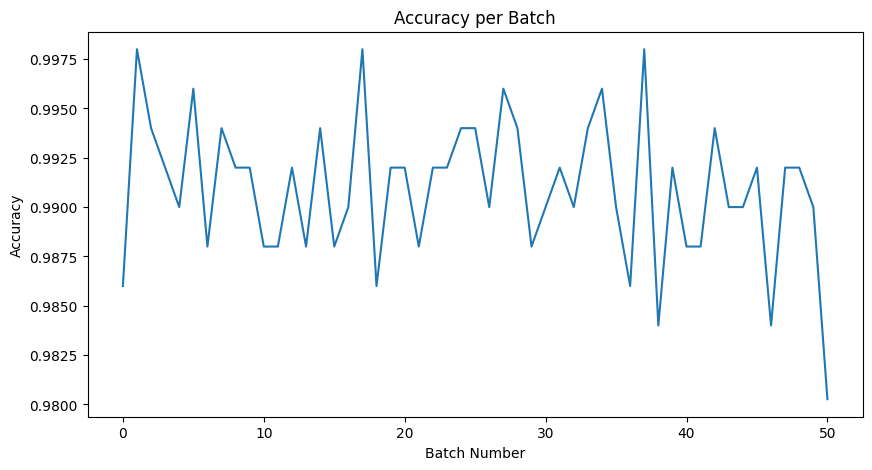

In [16]:
print(f"Overall accuracy: {overall_accuracy:.4f}")
print(f"Number of batches: {len(batch_accuracies)}")
print(f"Batch accuracies: {batch_accuracies[:5]}...") # Showing first 5 batch accuracies

# You can also plot the batch accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(batch_accuracies)
plt.title("Accuracy per Batch")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.show()

Take into account that the keys you use in the dictonary will be appended to the feature names. This is needed for spVIPES' to work properly.

An spVIPES model instance requires the previously generated adata together with the group and label keys.

In [10]:
spVIPES.model.spVIPES.setup_anndata(adata, groups_key='groups', match_clusters = False, transport_plan_key='transport_plan')

/opt/homebrew/Caskroom/miniforge/base/envs/spvipes_unsupervised/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/opt/homebrew/Caskroom/miniforge/base/envs/spvipes_unsupervised/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 24848 in adata.obs['_scvi_indices'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [11]:
spvipes = spVIPES.model.spVIPES(adata, n_dimensions_private=7, n_dimensions_shared=10)

INFO     spVIPES: The model has been initialized                                                                   


## spVIPES training

In order to train the model we need to specify the group cell indices

In [12]:
group_indices_list = [np.where(adata.obs['groups'] == group)[0] for group in adata.obs['groups'].unique()]

In [13]:
import warnings
warnings.filterwarnings("ignore")
spvipes.train(group_indices_list, batch_size=128, train_size=1.0)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 121/160:  75%|███████▌  | 120/160 [13:20<04:33,  6.83s/it, loss=5.28e+03, v_num=1]

spVIPES inherits scvi-tools functionality like model saving or training metrics

In [ ]:
spvipes.save("spvipes_model")

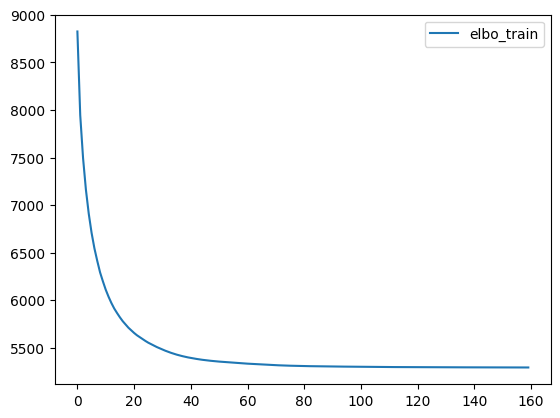

In [23]:
plt.plot(spvipes.history['elbo_train']['elbo_train'], label='elbo_train');
plt.legend()

Likewise we can also load a pretrained model

In [ ]:
spvipes = spVIPES.model.spVIPES.load("spvipes_model", adata=adata)

In [ ]:
spvipes

## Latent space retrieval and visualizaton

spVIPES outputs three sets of latent variables: 

- 2 private latents for each of the datasets used as input
- 1 shared latent, representing shared variation between the groups

In [55]:
adata[adata.obs.groups == 'dataset_1'].obs

,Group,Subgroup,sizeFactor,Dataset,Celltypes,Gene_programs,groups,indices,_scvi_batch,_scvi_groups,_scvi_indices
Cell1-dataset_1,Group5,Group1,0.967368,Dataset 1,Cell type 5,Gene program 1a,dataset_1,0,0,0,0
Cell2-dataset_1,Group3,Group1,0.855229,Dataset 1,Cell type 3,Gene program 1a,dataset_1,1,0,0,1
Cell4-dataset_1,Group3,Group2,0.816792,Dataset 1,Cell type 3,Gene program 2a,dataset_1,2,0,0,2
Cell8-dataset_1,Group1,Group1,0.944790,Dataset 1,Cell type 1,Gene program 1a,dataset_1,3,0,0,3
Cell9-dataset_1,Group4,Group1,1.163522,Dataset 1,Cell type 4,Gene program 1a,dataset_1,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
Cell49994-dataset_1,Group5,Group2,1.061826,Dataset 1,Cell type 5,Gene program 2a,dataset_1,24843,0,0,24843
Cell49996-dataset_1,Group1,Group2,0.653674,Dataset 1,Cell type 1,Gene program 2a,dataset_1,24844,0,0,24844
Cell49998-dataset_1,Group1,Group1,0.816222,Dataset 1,Cell type 1,Gene program 1a,dataset_1,24845,0,0,24845
Cell49999-dataset_1,Group3,Group1,0.802152,Dataset 1,Cell type 3,Gene program 1a,dataset_1,24846,0,0,24846


In [14]:
latent = spvipes.get_latent_representation(group_indices_list, batch_size=128)

In [15]:
latent_private_dataset1 = latent['private'][0]
latent_private_dataset2 = latent['private'][1]
latent_shared = np.concatenate((latent['shared'][0], latent['shared'][1]), axis=0)

In [61]:
latent_private_dataset1_reordered = latent['private_reordered'][0]
latent_private_dataset2_reordered = latent['private_reordered'][1]
latent_shared_reordered = np.concatenate((latent['shared_reordered'][0], latent['shared_reordered'][1]), axis=0)

In [17]:
latent_shared.shape

(49936, 10)

In [ ]:
np.save("spvipes_shared_embedding.npy", latent_shared)
np.save("spvipes_private_embedding_dataset1.npy", latent_private_dataset1)
np.save("spvipes_private_embedding_dataset2.npy", latent_private_dataset2)

We apply standard processing to the obtained embeddings

In [16]:
adata= adata[:len(latent_shared)]

In [17]:
adata.obsm['X_spVIPES_shared'] = latent_shared
sc.pp.neighbors(adata, use_rep="X_spVIPES_shared", key_added="spvipes_shared")
sc.tl.umap(adata, neighbors_key="spvipes_shared")
adata.obsm['X_umap_shared'] = adata.obsm['X_umap'].copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


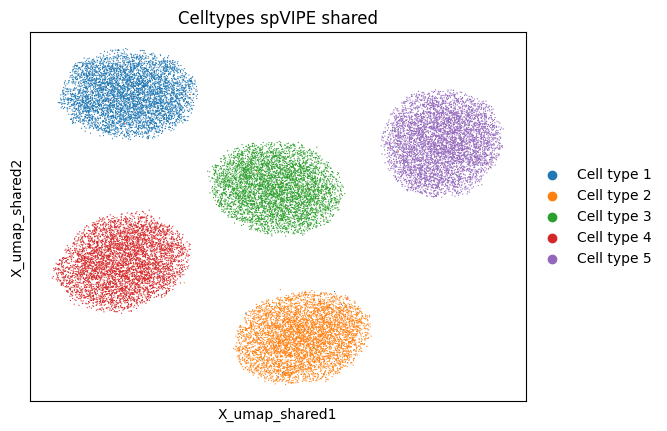

In [20]:
sc.pl.embedding(adata, basis='X_umap_shared', color=['Celltypes'], size=3, wspace=1, title="Celltypes spVIPE shared")

In [22]:
dataset1.obsm['X_spVIPES_private'] = latent_private_dataset1
sc.pp.neighbors(dataset1, use_rep="X_spVIPES_private", key_added="spvipes_private")
sc.tl.umap(dataset1, neighbors_key="spvipes_private")
dataset1.obsm['X_umap_private'] = dataset1.obsm['X_umap'].copy()

In [24]:
dataset2 = dataset2[:len(latent_private_dataset2)]

In [25]:
dataset2.obsm['X_spVIPES_private'] = latent_private_dataset2
sc.pp.neighbors(dataset2, use_rep="X_spVIPES_private", key_added="spvipes_private")
sc.tl.umap(dataset2, neighbors_key="spvipes_private")
dataset2.obsm['X_umap_private'] = dataset2.obsm['X_umap'].copy()

In [26]:
palette = sns.color_palette('Accent')

Private spaces should learn group-specific structure (i.e., gene programs in our simulated dataset) while learning no structure shared among groups (i.e., cell types). 

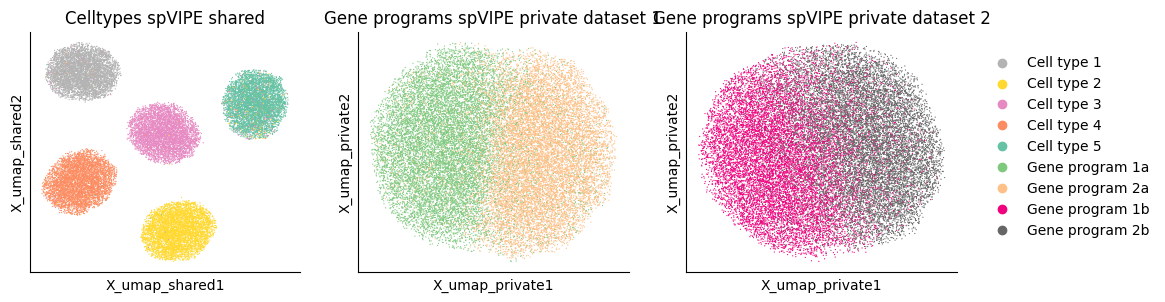

In [27]:
from operator import itemgetter
fig, axes = plt.subplots(1, 3, figsize=(10,3))
fig.tight_layout()
sc.pl.embedding(adata[adata.obs.groups == 'dataset_1'], basis='X_umap_shared', color=['Celltypes'], size=3, wspace=1, ax=axes[0], palette="Set2_r", show=False, title="Celltypes spVIPE shared")
sc.pl.embedding(dataset1, basis='X_umap_private', color=["Gene_programs"], size=3, wspace=1, ax=axes[1], palette=itemgetter(0,2)(palette), show=False, title="Gene programs spVIPE private dataset 1")
sc.pl.embedding(dataset2, basis='X_umap_private', color=["Gene_programs"], size=3, wspace=1, ax=axes[2], palette=itemgetter(5,7)(palette), show=False, title="Gene programs spVIPE private dataset 2")
sns.despine()
legends = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(item, []) for item in zip(*legends)]
for ax in axes:
    ax.get_legend().remove()
fig.legend(lines, labels, bbox_to_anchor=(1., 0.55), loc="center left", borderaxespad=0, frameon=False)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sc.pl.embedding(dataset1, basis='X_umap_private', color=["Celltypes"], size=10, wspace=1, palette="Set2_r", show=False, ax=axes[0], title="Gene programs spVIPE private dataset 1")
sc.pl.embedding(dataset2, basis='X_umap_private', color=["Celltypes"], size=10, wspace=1,  palette="Set2_r", show=False, ax=axes[1], title="Gene programs spVIPE private dataset 2")
sns.despine()
legends = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(item, []) for item in zip(*legends)]
for ax in axes:
    ax.get_legend().remove()
fig.legend(lines, labels, bbox_to_anchor=(1., 0.55), loc="center left", borderaxespad=0, frameon=False)
plt.show()

Qualitatively, the shared and private latent spaces learned by spVIPES capture shared and dataset-specific variation, respectively, but the private spaces do not capture shared variation for any of the datasets